In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd  # Untuk manipulasi data tabular
import numpy as np  # Untuk operasi numerik
import kagglehub  # Untuk mengunduh dataset dari Kaggle (pakai kagglehub)
import os  # Untuk operasi file/folder
import matplotlib.pyplot as plt  # Untuk visualisasi grafik

from sklearn.model_selection import train_test_split  # Untuk membagi data training dan testing
from sklearn.preprocessing import LabelEncoder  # Untuk mengubah label kategori menjadi angka
from sklearn.metrics import classification_report  # Untuk evaluasi model klasifikasi

from tensorflow.keras.preprocessing.text import Tokenizer  # Mengubah teks menjadi angka
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Menyamakan panjang input teks
from tensorflow.keras.models import Sequential  # Model berurutan (layer satu per satu)
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, Flatten  # Layer yang digunakan
from tensorflow.keras.callbacks import EarlyStopping  # Menghentikan training lebih awal jika model tidak membaik
from tensorflow.keras.utils import to_categorical  # Untuk mengubah label ke one-hot (tidak dipakai di sini)

In [ ]:
# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/emotions-dataset") # Unduh dataset dari KaggleHub

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/emotions-dataset


In [ ]:
path = "/kaggle/input/emotions-dataset"  # Path ke folder dataset di Kaggle
for root, dirs, files in os.walk(path):  # Tampilkan semua file di folder tersebut
    print("📁 Folder:", root)
    for file in files:
        print("  📄", file)


📁 Folder: /kaggle/input/emotions-dataset
  📄 emotions.csv


In [ ]:
df = pd.read_csv(os.path.join(path, "emotions.csv")) # Baca file emotions.csv ke dalam DataFrame
file_path = os.path.join(path, "emotions.csv")
df = pd.read_csv(file_path)

In [ ]:
# Label mapping (ubah angka ke teks)
label_map = { # Kamus untuk konversi label angka ke nama emosi
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

In [ ]:
# Ubah label numerik ke teks
df['label_text'] = df['label'].map(label_map) # Tambahkan kolom baru label_text berdasarkan mapping
print("\nLabel setelah konversi:\n", df['label_text'].value_counts()) # Hitung frekuensi tiap label


Label setelah konversi:
 label_text
joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: count, dtype: int64


In [ ]:
# Tampilkan hanya kolom text dan label_text
print(df[['text', 'label_text']].head())  # 5 data pertama

# Tampilkan jumlah data per label_text
print("\nJumlah data per label:")
print(df['label_text'].value_counts())

# Tokenisasi teks
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')  # Tokenizer dengan 10.000 kata terbanyak, token OOV untuk kata asing
tokenizer.fit_on_texts(df['text'])  # Pelajari kata-kata dari teks
sequences = tokenizer.texts_to_sequences(df['text'])  # Ubah teks jadi urutan angka
X = pad_sequences(sequences, maxlen=100, padding='post')  # Ubah semua ke panjang 100 (padding di akhir)

# Encode label
le = LabelEncoder()  # Encoder label dari string ke angka
y = le.fit_transform(df['label'])  # Ubah label ke angka

#Split Data
X_train, X_test, y_train, y_test = train_test_split(  # Bagi data untuk training dan testing
    X, y,
    test_size=0.2,  # 20% untuk data uji
    random_state=42  # Agar hasil konsisten setiap dijalankan
)

                                                text label_text
0      i just feel really helpless and heavy hearted       fear
1  ive enjoyed being able to slouch about relax a...    sadness
2  i gave up my internship with the dmrg and am f...       fear
3                         i dont know i feel so lost    sadness
4  i am a kindergarten teacher and i am thoroughl...       fear

Jumlah data per label:
label_text
joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: count, dtype: int64


In [ ]:
print(le.classes_) # Lihat urutan kelas

[0 1 2 3 4 5]


In [ ]:
len(df)

416809

In [ ]:
model = Sequential()  # Model bertipe sequential
model.add(Embedding(input_dim=10000, output_dim=64, input_length=100))  # Layer embedding dari kata ke vektor
model.add(GlobalAveragePooling1D())  # Rata-rata dari seluruh vektor
model.add(Dense(64, activation='relu'))  # Layer dense 64 neuron
model.add(Dropout(0.3))  # Dropout 30% untuk mencegah overfitting
model.add(Dense(32, activation='relu'))  # Layer dense lagi
model.add(Dense(len(le.classes_), activation='softmax'))  # Output sebanyak jumlah kelas, aktivasi softmax

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Kompilasi model
model.build(input_shape=(None, 100))  # Tentukan bentuk input
model.summary()  # Tampilkan arsitektur model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,438 (2.47 MB)

 Trainable params: 646,438 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Berhenti kalau val_loss tidak membaik setelah 3 epoch

# Training
history = model.fit(
    X_train, y_train,
    epochs=20,  # Maksimum 20 epoch
    batch_size=32,  # Jumlah data per batch
    validation_data=(X_test, y_test),  # Validasi selama training
    callbacks=[early_stop],  # Gunakan early stopping
    verbose=2  # Tampilkan hasil training
)

Epoch 1/20
10421/10421 - 37s - 4ms/step - accuracy: 0.7641 - loss: 0.6317 - val_accuracy: 0.8685 - val_loss: 0.3935
Epoch 2/20
10421/10421 - 38s - 4ms/step - accuracy: 0.8951 - loss: 0.2649 - val_accuracy: 0.8988 - val_loss: 0.2232
Epoch 3/20
10421/10421 - 29s - 3ms/step - accuracy: 0.9012 - loss: 0.2228 - val_accuracy: 0.8978 - val_loss: 0.2447
Epoch 4/20
10421/10421 - 40s - 4ms/step - accuracy: 0.9055 - loss: 0.2001 - val_accuracy: 0.9011 - val_loss: 0.2063
Epoch 5/20
10421/10421 - 41s - 4ms/step - accuracy: 0.9066 - loss: 0.1926 - val_accuracy: 0.8955 - val_loss: 0.2122
Epoch 6/20
10421/10421 - 41s - 4ms/step - accuracy: 0.9088 - loss: 0.1840 - val_accuracy: 0.8968 - val_loss: 0.2251
Epoch 7/20
10421/10421 - 33s - 3ms/step - accuracy: 0.9092 - loss: 0.1810 - val_accuracy: 0.9029 - val_loss: 0.1875
Epoch 8/20
10421/10421 - 28s - 3ms/step - accuracy: 0.9113 - loss: 0.1749 - val_accuracy: 0.9000 - val_loss: 0.2024
Epoch 9/20
10421/10421 - 45s - 4ms/step - accuracy: 0.9122 - loss: 0.171

In [ ]:
# Evaluasi akurasi
loss, accuracy = model.evaluate(X_test, y_test)  # Evaluasi di data uji
print(f"\n🎯 Akurasi Uji: {accuracy * 100:.2f}%")  # Tampilkan akurasi

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9022 - loss: 0.1887

🎯 Akurasi Uji: 90.29%


In [ ]:
# Prediksi
y_pred = model.predict(X_test).argmax(axis=1)  # Prediksi kelas dari output softmax

#Classification Report
target_names = list(label_map.values())  # Daftar nama label
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))  # Tampilkan precision, recall, f1-score


2606/2606 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

📋 Classification Report:
              precision    recall  f1-score   support

     sadness       0.92      0.96      0.94     24201
         joy       0.92      0.93      0.93     28164
        love       0.82      0.78      0.80      6929
       anger       0.94      0.86      0.90     11441
        fear       0.91      0.80      0.85      9594
    surprise       0.69      0.95      0.80      3033

    accuracy                           0.90     83362
   macro avg       0.87      0.88      0.87     83362
weighted avg       0.91      0.90      0.90     83362



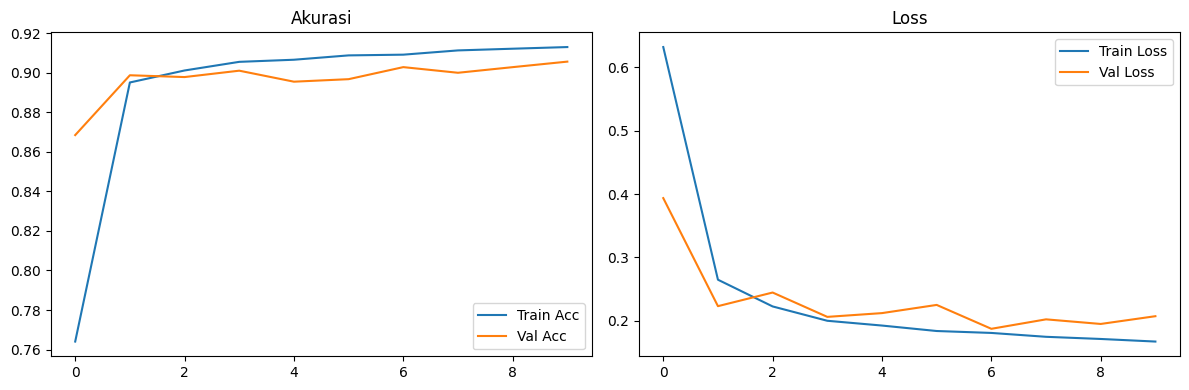

In [ ]:
# Grafik akurasi/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Konversi label angka ke bentuk teks
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# Tampilkan contoh 10 prediksi
print("\n🔍 Contoh Prediksi (10 data):")
for i in range(10):
    kalimat = tokenizer.sequences_to_texts([X_test[i]])[0]
    print(f"Teks: {kalimat}")
    print(f"👉 Prediksi: {y_pred_labels[i]} | Asli: {y_test_labels[i]}")
    print("---")


🔍 Contoh Prediksi (10 data):
Teks: id say maybe made them feel foolish but that would be <OOV> reaching <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
👉 Prediksi: 0 | Asli: 0
---
Teks: i joined the <OOV> church i admit to feeling somewhat ashamed of my family background in light of the mormon ideal that presented itself to me <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV

In [ ]:
label_dict = label_map  # Gunakan label_map sebagai label_dict

def prediksi_emosi(teks):
    """
    Fungsi untuk memprediksi emosi dari sebuah kalimat teks.
    Mengembalikan nama emosi dan indeks prediksi.
    """
    # Tokenisasi teks input
    seq = tokenizer.texts_to_sequences([teks])
    pad = pad_sequences(seq, maxlen=100, padding='post')  # Sesuaikan panjang input

    # Prediksi menggunakan model
    pred_index = model.predict(pad).argmax()

    # Ambil nama label
    label = label_dict.get(pred_index, "unknown")

    return f"Prediksi Emosi: {label})"


In [ ]:
contoh_teks = "I am so happy and excited today!"
print(prediksi_emosi(contoh_teks))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Prediksi Emosi: joy)
